In [ ]:
from re import I
from keras.layers import Dense, Flatten
from keras.models import Model
import tensorflow as tf

# vgg19
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob



In [ ]:

from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
device_list  = tf.test.gpu_device_name()
device_list

'/device:GPU:0'

(256, 170, 3)

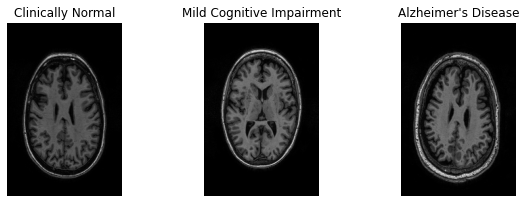

In [ ]:

fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 3
  
# reading images
Image1 = cv2.imread('/content/drive/MyDrive/Axial/val/CN/CN002_S_0413a084.png')
Image2 = cv2.imread('/content/drive/MyDrive/Axial/val/CI/CI002_S_0729a107.png')
Image3 = cv2.imread('/content/drive/MyDrive/Axial/val/AD/AD002_S_0816a078.png')
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Clinically Normal")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Mild Cognitive Impairment")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Alzheimer's Disease")
  
Image3.shape


In [ ]:

IMAGE_SIZE = [224,224]

trainImagesFolder = "/content/drive/MyDrive/Axial/train"
validationImagesFolder = "/content/drive/MyDrive/Axial/val"

# data augmentation

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                    shear_range = 0.4,
                                    zoom_range= 0.4,
                                    rotation_range=0.4,
                                    horizontal_flip= True)


valid_datagen = ImageDataGenerator( rescale= 1. / 255)


train_data_set = train_datagen.flow_from_directory(trainImagesFolder,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical')

                                                    
valid_data_set = valid_datagen.flow_from_directory(validationImagesFolder,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 4123 images belonging to 3 classes.
Found 515 images belonging to 3 classes.


In [ ]:
myVgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) 
# include_top=False -> remove the last fully connected layes from the VGG19 , so we can add our own layers

for layer in myVgg.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:

Classes = glob("/content/drive/MyDrive/Axial/train/*")
print(Classes)

classesNum = len(Classes)
print ('Number of Classes : ')
print(classesNum)

['/content/drive/MyDrive/Axial/train/AD', '/content/drive/MyDrive/Axial/train/CN', '/content/drive/MyDrive/Axial/train/CI']
Number of Classes : 
3


In [ ]:

model = Sequential()
model.add(myVgg)
model.add(Flatten())
model.add(Dense(classesNum , activation='softmax'))

print (model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 20,099,651
Trainable params: 75,267
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [ ]:

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint , EarlyStopping
checkpoint = ModelCheckpoint("/content/drive/MyDrive/h5model/trained.h5", 
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True)

earlystop = EarlyStopping(monitor='val_accuracy', patience=70 , verbose=1)                             

# fit the model (Training)
result = model.fit(train_data_set, validation_data= valid_data_set , epochs=100, verbose=1 , callbacks=[checkpoint,earlystop])



Epoch 1/100
129/129 [==============================] - ETA: 0s - loss: 1.1523 - accuracy: 0.5006
Epoch 1: val_accuracy improved from -inf to 0.66019, saving model to /content/drive/MyDrive/h5model/trained.h5
129/129 [==============================] - 1179s 9s/step - loss: 1.1523 - accuracy: 0.5006 - val_loss: 0.8322 - val_accuracy: 0.6602
Epoch 2/100
129/129 [==============================] - ETA: 0s - loss: 0.9342 - accuracy: 0.5743
Epoch 2: val_accuracy did not improve from 0.66019
129/129 [==============================] - 56s 436ms/step - loss: 0.9342 - accuracy: 0.5743 - val_loss: 1.3399 - val_accuracy: 0.5359
Epoch 3/100
129/129 [==============================] - ETA: 0s - loss: 0.9390 - accuracy: 0.5770
Epoch 3: val_accuracy did not improve from 0.66019
129/129 [==============================] - 56s 437ms/step - loss: 0.9390 - accuracy: 0.5770 - val_loss: 0.8939 - val_accuracy: 0.6369
Epoch 4/100
129/129 [==============================] - ETA: 0s - loss: 0.7747 - accuracy: 0.661

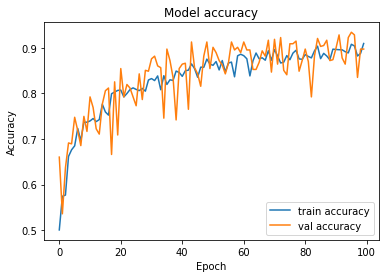

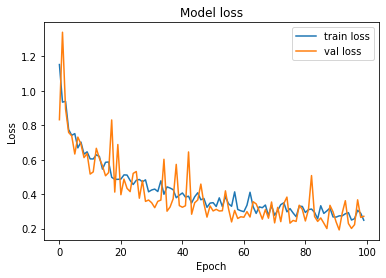

In [ ]:
# plot accuracy 
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.show()

# plot loss 
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
import os

print(Classes)

['/content/drive/MyDrive/Axial/train/AD', '/content/drive/MyDrive/Axial/train/CN', '/content/drive/MyDrive/Axial/train/CI']


In [ ]:
testImagesFolder = "/content/drive/MyDrive/Axial/test"

test_datagen = ImageDataGenerator(rescale = 1./255)

test_data_set = test_datagen.flow_from_directory(testImagesFolder,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 517 images belonging to 3 classes.


In [ ]:
model.evaluate(test_data_set)

17/17 [==============================] - 74s 5s/step - loss: 0.2509 - accuracy: 0.9070


[0.2508704662322998, 0.9069767594337463]

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/h5model/trained.h5')

In [ ]:
overall_result = model.evaluate(test_data_set)
overall_result

17/17 [==============================] - 212s 13s/step - loss: 0.2029 - accuracy: 0.9362


[0.20291908085346222, 0.936170220375061]

In [ ]:
AD_testImagesFolder = "/content/drive/MyDrive/Axial/test/AD"

test_datagen = ImageDataGenerator(rescale = 1./255)

AD_test_data_set = test_datagen.flow_from_directory(AD_testImagesFolder,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 114 images belonging to 1 classes.


In [ ]:
AD_result = model.evaluate(AD_test_data_set)
AD_result

4/4 [==============================] - 77s 18s/step - loss: 10.7324 - accuracy: 0.9386


[10.732358932495117, 0.9385964870452881]

In [ ]:
overall_predict = model.predict(test_data_set) 
overall_predict

17/17 [==============================] - 136s 8s/step


array([[1.0392453e-03, 4.1298449e-01, 5.8597624e-01],
       [9.9610317e-01, 2.3390616e-03, 1.5578107e-03],
       [7.6276749e-01, 1.7223518e-01, 6.4997293e-02],
       ...,
       [8.7237416e-04, 1.3321577e-01, 8.6591190e-01],
       [9.0554619e-04, 1.6633321e-02, 9.8246115e-01],
       [8.2538188e-01, 1.5960850e-01, 1.5009606e-02]], dtype=float32)

In [ ]:
print(test_data_set)